In [48]:
import pandas as pd
import numpy as np
import pymc as pm
from src.data_utils import load_and_process_data
from src.model import run_full_analysis, build_and_sample_model
from src.trace_save_load import load_previous_season_trace, extract_previous_season_priors, save_season_trace
import matplotlib.pyplot as plt

league = ['Premier_League']
season = '2025-2026'


# Simple one-liner to get everything ready
df, team_mapping, n_teams = load_and_process_data(
    db_path=r'C:\Users\Owner\dev\algobetting\infra\data\db\fotmob.db',
    league=league, 
    season=season,
    max_goals=9,
    decay_rate=0.002,
    goals_weight=0.5,
    xg_weight=0.5,
    psxg_weight=0.3

)

df

,match_id,league_id,match_date,home_team,away_team,home_goals,away_goals,weight,days_ago,is_actual,poisson_binomial_xg_prob,poisson_binomial_psxg_prob,poisson_xg_total_prob,home_idx,away_idx
0,4813374,Premier_League,2025-08-15,Liverpool,Bournemouth,0,0,5.66e-03,36,False,9.88e-03,2.82e-03,2.02e-02,11,2
1,4813374,Premier_League,2025-08-15,Liverpool,Bournemouth,0,1,9.43e-03,36,False,2.36e-02,3.58e-03,3.43e-02,11,2
2,4813374,Premier_League,2025-08-15,Liverpool,Bournemouth,0,2,7.73e-03,36,False,2.27e-02,1.25e-03,2.92e-02,11,2
3,4813374,Premier_League,2025-08-15,Liverpool,Bournemouth,0,3,4.28e-03,36,False,1.18e-02,7.26e-05,1.65e-02,11,2
4,4813374,Premier_League,2025-08-15,Liverpool,Bournemouth,0,4,1.81e-03,36,False,3.64e-03,0.00e+00,7.01e-03,11,2
5,4813374,Premier_League,2025-08-15,Liverpool,Bournemouth,0,5,6.16e-04,36,False,7.00e-04,0.00e+00,2.38e-03,11,2
6,4813374,Premier_League,2025-08-15,Liverpool,Bournemouth,1,0,1.60e-02,36,False,3.21e-02,2.87e-02,4.47e-02,11,2
7,4813374,Premier_League,2025-08-15,Liverpool,Bournemouth,1,1,2.53e-02,36,False,7.67e-02,3.64e-02,7.59e-02,11,2
8,4813374,Premier_League,2025-08-15,Liverpool,Bournemouth,1,2,1.86e-02,36,False,7.39e-02,1.27e-02,6.45e-02,11,2
9,4813374,Premier_League,2025-08-15,Liverpool,Bournemouth,1,3,9.55e-03,36,False,3.83e-02,7.39e-04,3.65e-02,11,2


In [49]:
df[df["match_id"] == 4813374]["weight"].sum()

0.9305308958112058

In [50]:
# manual priors

# Attack strength priors (mu, sigma)
# Using sigma=0.1 for tighter priors based on historical data
manual_att_priors = {
    'Arsenal': (0.198, 0.15),
    'Aston Villa': (0.121, 0.15),
    'Bournemouth': (0.100, 0.15),
    'Brentford': (0.079, 0.15),
    'Brighton': (0.083, 0.15),
    'Chelsea': (0.185, 0.15),
    'Crystal Palace': (0.057, 0.15),
    'Everton': (-0.108, 0.15),
    'Fulham': (-0.030, 0.15),
    'Liverpool': (0.371, 0.15),
    'Man City': (0.297, 0.15),
    'Man United': (0.011, 0.15),
    'Newcastle': (0.207, 0.15),
    'Nottm Forest': (-0.003, 0.15),
    'Tottenham': (0.121, 0.15),
    'West Ham': (-0.082, 0.15),
    'Wolves': (-0.094, 0.15),

    'Burnley': (-0.287, 0.25),
    'Leeds': (-0.070, 0.25),
    'Sunderland': (-0.266, 0.25)
}

# Defense strength priors (mu, sigma)
# Using sigma=0.1 for tighter priors based on historical data
manual_def_priors = {
    'Arsenal': (-0.340, 0.15),
    'Aston Villa': (-0.085, 0.15),
    'Bournemouth': (-0.001, 0.15),
    'Brentford': (-0.054, 0.15),
    'Brighton': (0.107, 0.15),
    'Chelsea': (-0.166, 0.15),
    'Crystal Palace': (0.052, 0.15),
    'Everton': (-0.085, 0.15),
    'Fulham': (-0.014, 0.15),
    'Liverpool': (-0.222, 0.15),
    'Man City': (-0.191, 0.15),
    'Man United': (-0.035, 0.15),
    'Newcastle': (-0.083, 0.15),
    'Nottm Forest': (-0.046, 0.15),
    'Tottenham': (0.163, 0.15),
    'West Ham': (0.103, 0.15),
    'Wolves': (0.137, 0.15),

    'Burnley': (0.020, 0.25),
    'Leeds': (0.037, 0.25),
    'Sunderland': (0.267, 0.25)
}



In [51]:
model, trace = build_and_sample_model(
     df, 
     n_teams, 
     team_mapping=team_mapping,
     trace=10000,
     tune=5000,
     manual_att_priors=manual_att_priors,
     manual_def_priors=manual_def_priors
 )

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
att_str_raw[0]   0.232  0.141  -0.035    0.496      0.002    0.001    7378.0    2854.0   1.00
att_str_raw[1]   0.049  0.145  -0.230    0.319      0.002    0.003    8188.0    3027.0   1.00
att_str_raw[2]   0.086  0.144  -0.193    0.351      0.002    0.002    6338.0    2758.0   1.00
att_str_raw[3]   0.078  0.140  -0.183    0.342      0.002    0.002    7237.0    2897.0   1.00
att_str_raw[4]   0.098  0.137  -0.168    0.353      0.002    0.002    7587.0    2751.0   1.00
att_str_raw[5]  -0.253  0.211  -0.686    0.106      0.003    0.002    6097.0    2783.0   1.00
att_str_raw[6]   0.244  0.142  -0.011    0.517      0.002    0.002    6475.0    2808.0   1.00
att_str_raw[7]   0.058  0.140  -0.195    0.323      0.002    0.002    6029.0    3257.0   1.00
att_str_raw[8]  -0.096  0.135  -0.363    0.158      0.002    0.002    7419.0    2919.0   1.00
att_str_raw[9]  -0.019  0.141  -0.289    0.232      0.002   

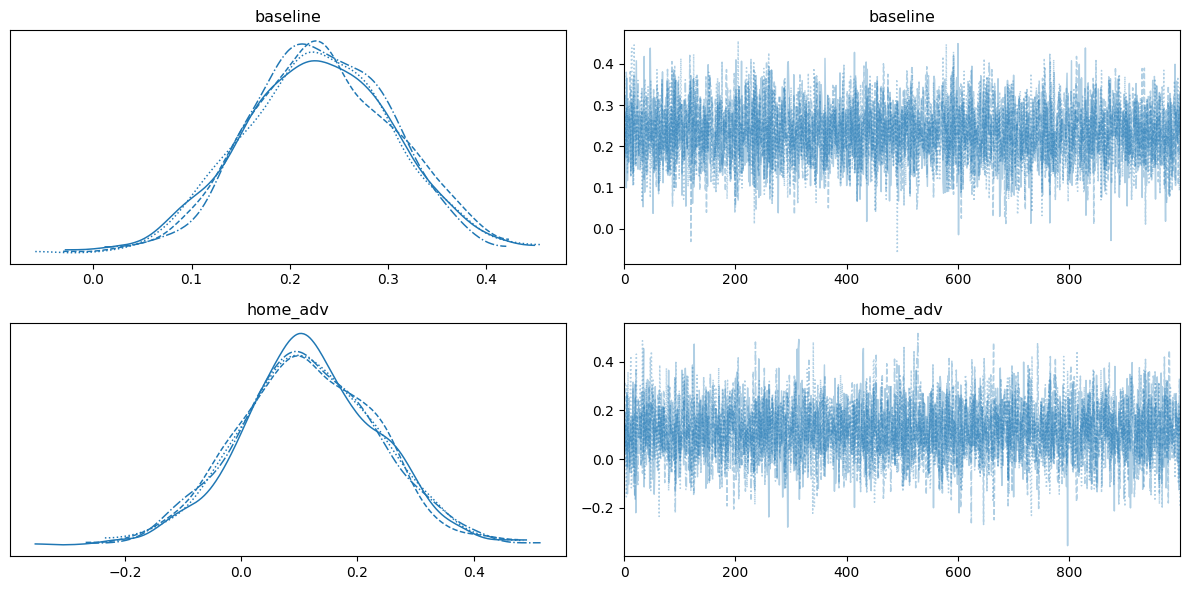

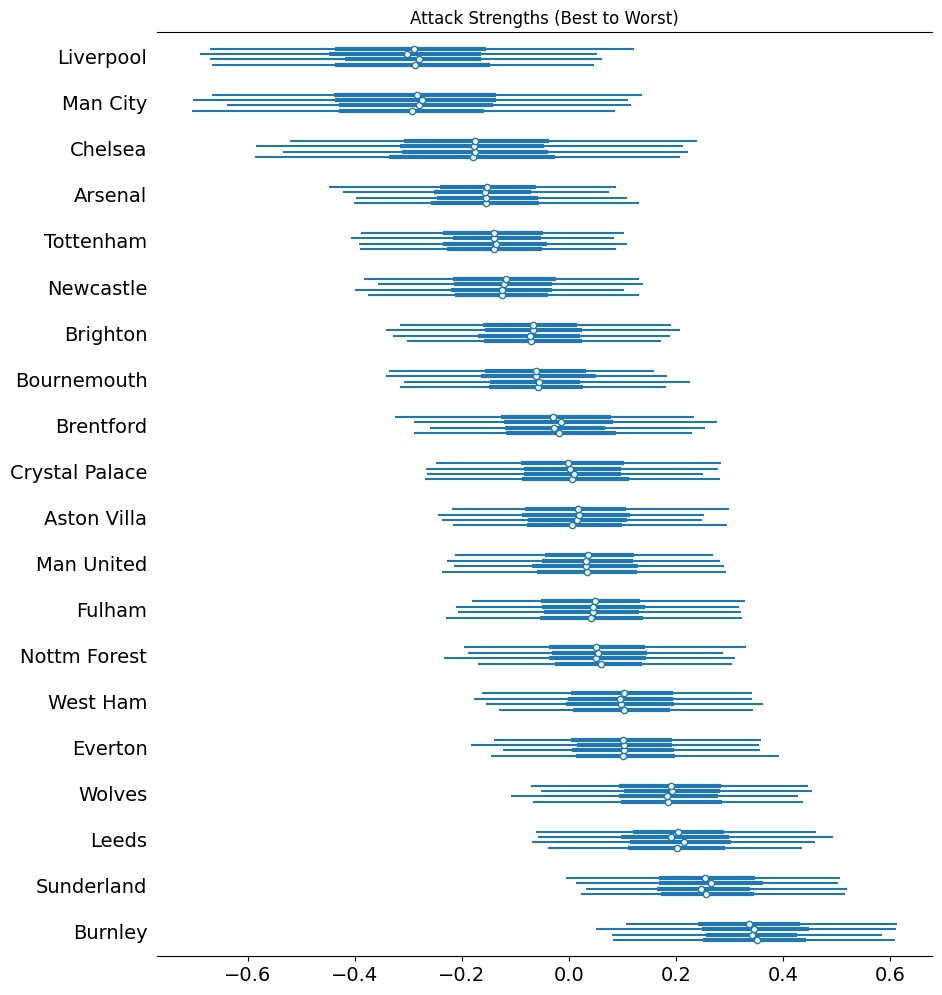

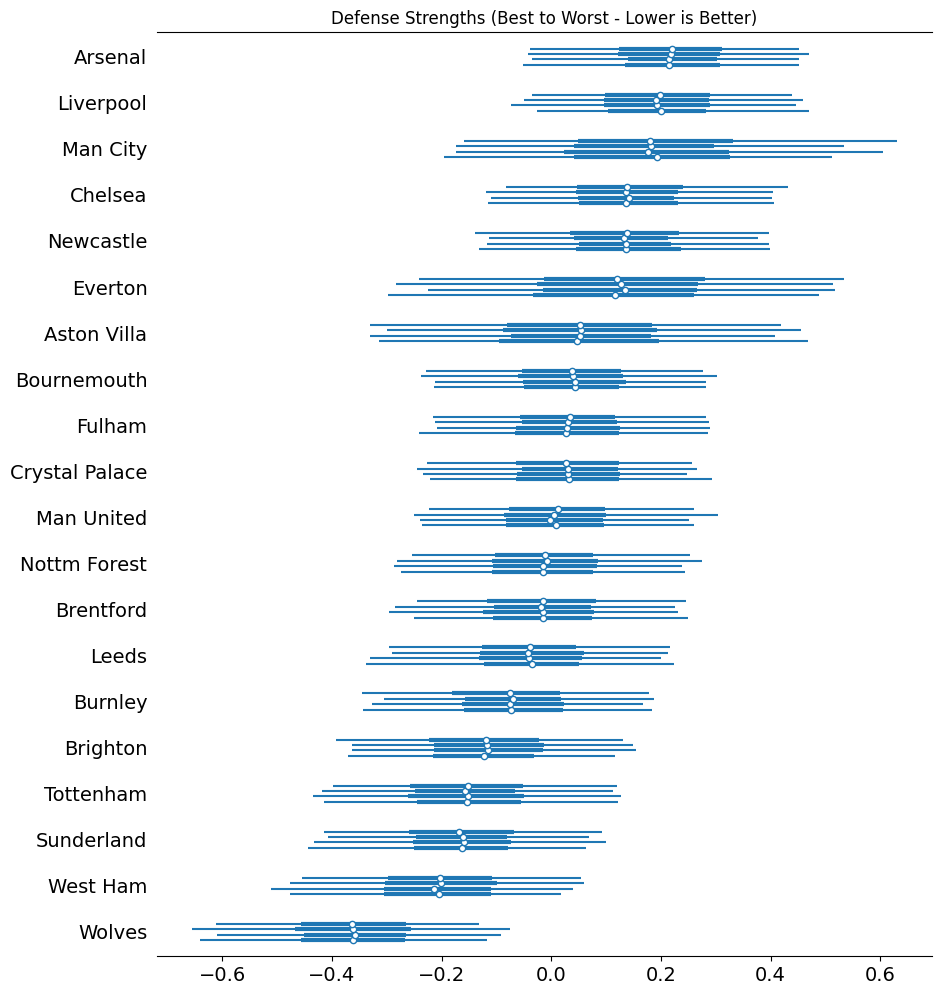


BEST ATTACKS:
              team  strength
11       Liverpool     0.343
12        Man City     0.257
6          Chelsea     0.200
0          Arsenal     0.189
17       Tottenham     0.102
14       Newcastle     0.099
4         Brighton     0.055
2      Bournemouth     0.042
3        Brentford     0.035
7   Crystal Palace     0.014
1      Aston Villa     0.006
13      Man United    -0.021
9           Fulham    -0.062
15    Nottm Forest    -0.072
18        West Ham    -0.125
8          Everton    -0.140
19          Wolves    -0.156
10           Leeds    -0.178
16      Sunderland    -0.290
5          Burnley    -0.296

BEST DEFENSES:
              team  strength
0          Arsenal    -0.361
11       Liverpool    -0.205
12        Man City    -0.164
6          Chelsea    -0.154
14       Newcastle    -0.119
8          Everton    -0.073
1      Aston Villa    -0.039
2      Bournemouth    -0.017
9           Fulham    -0.013
7   Crystal Palace     0.006
13      Man United     0.030
15    Nottm 

In [52]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

# Quick summary - full table display with 2 decimal places
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)  # Prevents wrapping
pd.set_option('display.precision', 3)  # 2 decimal places

summary = az.summary(trace)
print(summary)

# Quick plots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Trace plots for key parameters
az.plot_trace(trace, var_names=['baseline', 'home_adv'], axes=axes)
plt.tight_layout()
plt.show()

# Extract team rankings FIRST
summary = az.summary(trace)

# Attack rankings (highest values first)
att_ranks = []
for team, idx in team_mapping.items():
    att_ranks.append({
        'team': team, 
        'strength': summary.loc[f'att_str[{idx}]', 'mean']
    })
att_df = pd.DataFrame(att_ranks).sort_values('strength', ascending=False)

# Defense rankings (lowest/most negative values first - best defense)  
def_ranks = []
for team, idx in team_mapping.items():
    def_ranks.append({
        'team': team,
        'strength': summary.loc[f'def_str[{idx}]', 'mean'] 
    })
def_df = pd.DataFrame(def_ranks).sort_values('strength', ascending=True)

# Now create ordered team name lists
att_ordered_teams = att_df['team'].tolist()  # Best attack to worst
def_ordered_teams = def_df['team'].tolist()  # Best defense to worst

# Get ordered indices
att_ordered_indices = [team_mapping[team] for team in att_ordered_teams]
def_ordered_indices = [team_mapping[team] for team in def_ordered_teams]

# Attack strengths plot (best at top)
az.plot_forest(trace, var_names=['att_str'], 
               coords={'att_str_dim_0': att_ordered_indices[::-1]},
               figsize=(10, 12))
plt.title('Attack Strengths (Best to Worst)')
plt.gca().set_yticklabels(att_ordered_teams[::-1])
plt.show()

# Defense strengths plot (best at top)
az.plot_forest(trace, var_names=['def_str'],
               coords={'def_str_dim_0': def_ordered_indices[::-1]}, 
               figsize=(10, 12))
plt.title('Defense Strengths (Best to Worst - Lower is Better)')
plt.gca().set_yticklabels(def_ordered_teams[::-1])
plt.show()

# Print rankings
print("\nBEST ATTACKS:")
print(att_df.head(20))

print("\nBEST DEFENSES:")
print(def_df.head(20))

In [ ]:
# Team ratings vs average team (0 rating)
import numpy as np

# Get baseline and home advantage from trace
baseline_mean = summary.loc['baseline', 'mean']
home_adv_mean = summary.loc['home_adv', 'mean']

print("=== TEAM RATINGS VS AVERAGE TEAM ===")
print(f"Baseline (neutral venue): {baseline_mean:.3f}")
print(f"Home advantage: {home_adv_mean:.3f}")
print()

# Calculate goals for/against vs average team (0,0 ratings)
team_ratings = []

for team, idx in team_mapping.items():
    att_strength = summary.loc[f'att_str[{idx}]', 'mean']
    def_strength = summary.loc[f'def_str[{idx}]', 'mean']
    
    # Goals scored vs average team at home
    goals_for = np.exp(baseline_mean + att_strength + 0 )  # vs avg def (0)

    
    # Goals conceded vs average team away
    goals_against = np.exp(baseline_mean + 0 + def_strength)  # avg att (0) with home adv
    
    goal_difference = goals_for - goals_against
    
    team_ratings.append({
        'team': team,
        'goals_for': goals_for,
        'goals_against': goals_against,
        'goal_diff_vs_avg': goal_difference,
    })

# Convert to DataFrame and sort by goal difference
ratings_df = pd.DataFrame(team_ratings)
ratings_df = ratings_df.sort_values('goal_diff_vs_avg', ascending=False)

# Display main table
print("TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):")
print("=" * 80)
display_df = ratings_df[['team', 'goals_for', 'goals_against', 'goal_diff_vs_avg']].copy()

pd.set_option('display.precision', 2)
print(display_df.to_string(index=False))

=== TEAM RATINGS VS AVERAGE TEAM ===
Baseline (neutral venue): 0.231
Home advantage: 0.116

TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):
          team  goals_for  goals_against  goal_diff_vs_avg
     Liverpool       1.78           1.03          7.49e-01
       Arsenal       1.52           0.88          6.44e-01
      Man City       1.63           1.07          5.60e-01
       Chelsea       1.54           1.08          4.59e-01
     Newcastle       1.39           1.12          2.72e-01
   Bournemouth       1.31           1.24          7.53e-02
   Aston Villa       1.27           1.21          5.58e-02
Crystal Palace       1.28           1.27          1.02e-02
     Brentford       1.30           1.31         -5.23e-03
     Tottenham       1.40           1.45         -5.11e-02
        Fulham       1.18           1.24         -5.95e-02
    Man United       1.23           1.30         -6.45e-02
       Everton       1.10           1.17         -7.59e-02
      Brighton       1.3

In [54]:
# Convert team_mapping dict to list of team names in index order
team_names = [None] * len(team_mapping)
for team, idx in team_mapping.items():
    team_names[idx] = team

# Save the trace with team names
trace_path = save_season_trace(
    trace=trace,
    season_year=2025,  # Replace with your actual season year
    league="Premier_League",       # Replace with your league code (e.g., "PL", "La Liga", etc.)
    team_names=team_names,
    model_version="manual_priors"
)

print(f"Trace saved to: {trace_path}")

Saved trace for 2025
Trace saved to: model_traces\manual_priors\trace_Premier_League_2025.nc


In [57]:
import numpy as np
import pandas as pd

def predict_match(home_team, away_team, trace, team_mapping):
    """
    Predict goals for a match between two teams
    
    Parameters:
    home_team: str - name of home team
    away_team: str - name of away team  
    trace: pymc trace object
    team_mapping: dict - maps team names to indices
    
    Returns:
    dict with predictions
    """
    
    # Get team indices
    home_idx = team_mapping[home_team]
    away_idx = team_mapping[away_team]
    
    # Extract posterior samples
    att_str = trace.posterior['att_str'].values.reshape(-1, len(team_mapping))
    def_str = trace.posterior['def_str'].values.reshape(-1, len(team_mapping))
    baseline = trace.posterior['baseline'].values.flatten()
    home_adv = trace.posterior['home_adv'].values.flatten()
    
    # Calculate expected goals for each posterior sample
    home_goals_lambda = np.exp(
        baseline + 
        att_str[:, home_idx] + 
        def_str[:, away_idx] + 
        home_adv
    )
    
    away_goals_lambda = np.exp(
        baseline + 
        att_str[:, away_idx] + 
        def_str[:, home_idx]
    )
    
    # Generate actual goal predictions using Poisson
    home_goals_pred = np.random.poisson(home_goals_lambda)
    away_goals_pred = np.random.poisson(away_goals_lambda)
    
    return {
        'home_team': home_team,
        'away_team': away_team,
        'home_goals_expected': np.mean(home_goals_lambda),
        'away_goals_expected': np.mean(away_goals_lambda),
        'home_goals_median': np.median(home_goals_pred),
        'away_goals_median': np.median(away_goals_pred),
        'home_win_prob': np.mean(home_goals_pred > away_goals_pred),
        'draw_prob': np.mean(home_goals_pred == away_goals_pred), 
        'away_win_prob': np.mean(home_goals_pred < away_goals_pred)
    }

# Predict multiple matches
matches = [
    ('Aston Villa', 'Fulham'),
    ('Brentford', 'Man United'),
    ('Chelsea', 'Brighton'),
    ('Crystal Palace', 'Liverpool'),
    ('Everton', 'West Ham'),
    ('Leeds', 'Bournemouth'),
    ('Man City', 'Burnley'),
    ('Newcastle', 'Arsenal'),
    ('Nottm Forest', 'Sunderland'),
    ('Tottenham', 'Wolves')
]

print("\n" + "="*60)
print("MATCH PREDICTIONS")
print("="*60)

total_goals = 0
for home, away in matches:
    result = predict_match(home, away, trace, team_mapping)
    match_total = result['home_goals_expected'] + result['away_goals_expected']
    total_goals += match_total
    print(f"{home:15} vs {away:15}: {result['home_goals_expected']:.2f}-{result['away_goals_expected']:.2f} "
          f"({result['home_win_prob']:.0%}-{result['draw_prob']:.0%}-{result['away_win_prob']:.0%}) "
          f"Total: {match_total:.1f}")

print("="*60)
print(f"TOTAL GOALS ACROSS ALL MATCHES: {total_goals:.2f}")
print(f"AVERAGE GOALS PER MATCH: {total_goals/len(matches):.2f}")


MATCH PREDICTIONS
Aston Villa     vs Fulham         : 1.44-1.16 (44%-25%-31%) Total: 2.6
Brentford       vs Man United     : 1.54-1.31 (43%-24%-33%) Total: 2.9
Chelsea         vs Brighton       : 2.03-1.17 (57%-21%-22%) Total: 3.2
Crystal Palace  vs Liverpool      : 1.20-1.83 (25%-23%-52%) Total: 3.0
Everton         vs West Ham       : 1.53-1.06 (49%-25%-26%) Total: 2.6
Leeds           vs Bournemouth    : 1.21-1.43 (32%-26%-42%) Total: 2.6
Man City        vs Burnley        : 2.15-0.82 (67%-19%-15%) Total: 3.0
Newcastle       vs Arsenal        : 1.12-1.38 (32%-26%-42%) Total: 2.5
Nottm Forest    vs Sunderland     : 1.63-1.01 (51%-24%-24%) Total: 2.6
Tottenham       vs Wolves         : 2.00-1.26 (52%-23%-25%) Total: 3.3
TOTAL GOALS ACROSS ALL MATCHES: 28.28
AVERAGE GOALS PER MATCH: 2.83
